## COGS 108 - Final Project: 

# An Analysis of Effects on Racial Demographics at 4-Year U.S. Universities

# Overview

With the dramatic rise of financial aid, the strive and responsibility for the United States to make all opportunities equal has increase; along with that increase is the desire for a more diverse college population. Our group is curious as to how the racial demographic in both top-tier and bottom colleges compare to the racial demographics of the county in which the university is located. In addition, our group wanted to see if any relationship exists between the racial demographics of top universities and the size of the corresponding universities' undergraduation populations. Our analysis did determine some weak relationships; however, due to the many limitations, further research is needed.

# Names - Group 17

- Neve Foresti (data cleaning, analysis & results 1)
- Emily Chou (data wrangling, data cleaning, analysis & results 1)
- Sahba Mobini Farahani (ethics & privacy, analysis & results 2)
- Belen Romero (data exploration, conclusion, background)
- Marie Paris (overview, background, analysis & results 2, conclusion)

# Research Question

Is the undergraduate racial demographics of universities affected by external factors such as university undergraduate size or the racial demographics of each institution's surrounding county?

## Background and Prior Work

There has been some data to show that college ready, high-school students are continuously applying to schools that are near metropolitan cities because of the desire of excitement expected in a major city. Thus, top-tier educational institutions are conveniently located close to, or are neighboring, major metropolitan cities, such as New York or Boston. In other cases, top ranked institutions are located in what are now coming to be known as “university cities.” These college towns are a new breed of city that stands apart from the usual hustle and bustle of that we are accustomed to seeing. These cities present a myriad of interesting attributes. They are a unique urban environment which consists of low crime rates, high population education level, and increased participation within the arts. These are densely-populated environments that we would expect to see in major cities, yet they are characteristically closer to a suburban environment. That leads us to the question of racial demographics. With this new breed of city on the rise, we can start to take a closer look at what kind of environment the average college student is living and learning in. A traditional metropolitan city would usually have a large amount of diversity, while a University City would not. This leads to the interest in how the racial gap between the university and city can play into the change of the county based on the racial make-up of the college in that area.

In our exploration we looked at the national level for differences between college students and the racial demographic of all people in the United States. When looking at multiple forms of Census data, we can already see the variety in the types of breakdowns of Race and Ethnicity that are the most common. US Census data has a very limited amount of racial and ethnic breakdown. The Census only officially acknowledges Non-Hispanic and Hispanic as ethnicities in their data. There are also a limited number of races that the Census considers in their data. Since the US Census is typically the most accurate dataset in the United States, we will likely be facing issues similar to these when using any dataset involving demographics, unless we use data from a separate source.

There is also the issue of age range when looking at the publicly available datasets involving personal data. The most obvious issue is that data is generalized into percentages or trends/trend changes. This can be due to a couple of different reasons such as keeping information private. The US Census does allow researchers to access their data after if needed and approved for use in their research, but it is not information that is easily given out. This means that we cannot combine the two variables of race and age and cannot create an accurate portrayal of the differences between the people who are in college and all college-aged people in the United States.

References:
- 1) https://nces.ed.gov/programs/coe/pdf/coe_cpb.pdf
- 2) https://www.insidehighered.com/news/2017/05/04/author-discusses-new-book-relationships-including-tensions-over-race-and-economics

# Hypothesis


#### Hypothesis for Analysis One: 
Lower ranked schools will have higher racial demographic similarity with the surrounding county than higher ranked schools.  Famous colleges are also under more pressure to admit a diverse range of students in terms of racial demographics. Lower ranked universities tend to have more local students who often pay lower admission fees or are not looking to attend schools outside of their county. 

#### Hypothesis for Analysis Two: 
Larger unviersities represent a more diverse student body compared to smaller universities. We predict the top tier of undergraduate population are more diverse because bigger universities pull more student applications and therefore are exposed to a more diverse pool of potential students. 

# Dataset(s)

### 1. Census Data
- Dataset Name: U.S. Census Bureau
- Link to the dataset: https://www.census.gov/quickfacts
- Number of observations: all law abiding U.S. citizens over 18 in specified area/63 categories for each city and county/10 cities/10 counties
- Variables Included: 
    1. White alone, percent
    2. Black or African American alone, percent
    3. American Indian and Alaska Native alone, percent
    4. Asian alone, percent
    5. Native Hawaiian and Other Pacific Islander alone, percent
    6. Two or More Races, percent
    7. Hispanic or Latino, percent
    8. White alone, not Hispanic or Latino, percent

This dataset provides varying information on specific cities and counties such as racial demographics and population. 

### 2. Niche College Data
- Dataset Name: Niche.com 4-Year Best Colleges
- Link to the dataset: https://www.niche.com/colleges/search/best-colleges/
- Number of observations: 880
- Variables Included:
    1. ranking
    2. African American
    3. Asian
    4. Hispanic
    5. International
    6. Multiracial
    7. Native American
    8. Pacific Islander
    9. Unknown
    10. White
    11. Name

This website provides information related to all ranked (880) 4-year public and private colleges in the United States. We will be scraping undergraduate population and racial demographic data from this website (and got permission from Niche to do so).

### Combining the data:
The census data will be used in tandem with the college dataset in order to compare the relationships between racial demographic data of colleges and the counties they are located in. 

# Setup

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb #to run this you will need to type into your terminal: pip install import-ipynb
import patsy
import statsmodels.api as sm
import os
import re
import seaborn as sns
from collections import OrderedDict
from scipy.stats import uniform, norm, bernoulli, poisson, pearsonr
import warnings
warnings.filterwarnings("ignore")

pd.set_option('precision', 2)
pd.set_option('display.max_rows', 10)

# Data Wrangling

All data on cities and counties were sourced from https://www.census.gov/quickfacts.

Because we will be analyzing the impact, if any, of variously ranked colleges on the respective cities and counties they are located in, we want the data to be organized based on ranking, allowing us to easily isolate the analysis.

The U.S. Census Bureau provides us tables with the following data.

In [2]:
cities_dataset_path = './datasets/cities/'
counties_dataset_path = './datasets/counties/'

# create separate dictionaries for each category of colleges that the cities are home to
top_cities = dict()
mid_cities = dict()
bot_cities = dict()
other_cities = dict() # misc areas for further analysis

# populate dicts based on filename indicators
for c in os.listdir(cities_dataset_path):
    # filenames truncated to city-state format for simplicity
    truncated_file_name = '-'.join((c.split('-')[:2]))
    if c.endswith("top-city.csv"):
        top_cities[truncated_file_name] = pd.read_csv(cities_dataset_path + c)
    elif c.endswith("mid-city.csv"):
        mid_cities[truncated_file_name] = pd.read_csv(cities_dataset_path + c)
    elif c.endswith("bot-city.csv"):
        bot_cities[truncated_file_name] = pd.read_csv(cities_dataset_path + c)
    elif '-' in c:
        other_cities[truncated_file_name] = pd.read_csv(cities_dataset_path + c)

# similar process for counties
top_counties = dict()
mid_counties = dict()
bot_counties = dict()
other_counties = dict()

for c in os.listdir(counties_dataset_path):
    # filenames truncated to county-state format for simplicity
    truncated_file_name = '-'.join((c.split('-')[:2]))
    if c.endswith("top-county.csv"):
        top_counties[truncated_file_name] = pd.read_csv(counties_dataset_path + c)
    elif c.endswith("mid-county.csv"):
        mid_counties[truncated_file_name] = pd.read_csv(counties_dataset_path + c)
    elif c.endswith("bot-county.csv"):
        bot_counties[truncated_file_name] = pd.read_csv(counties_dataset_path + c)
    elif '-' in c:
        other_counties[truncated_file_name] = pd.read_csv(counties_dataset_path + c)

# testing
print('============== TOP TEST ===============')
print(top_cities['stanford-ca'])
print('\n============== MID TEST ===============')
print(mid_cities['whitewater-wi'])
print('\n============== BOT TEST ===============')
print(bot_counties['westmoreland-pa'])

============== TOP TEST ===============
                                                 Fact  \
0        Population estimates, July 1, 2018,  (V2018)   
1   Population estimates base, April 1, 2010,  (V2...   
2   Population, percent change - April 1, 2010 (es...   
3                   Population, Census, April 1, 2010   
4                      Persons under 5 years, percent   
..                                                ...   
77                                                 FN   
78                                                NaN   
79                                                  S   
80                                                  X   
81                                                  Z   

                                            Fact Note  \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                              

# Data Cleaning and Pre-processing

## 1. Preparing County & City Data

In [3]:
all_csv = [top_cities, mid_cities, bot_cities, other_cities, top_counties, mid_counties, bot_counties, other_counties]
for d in all_csv:
    for k, v in d.items():
        v.rename(index = str, columns = {v.columns[2] : 'Fact Value'}, inplace = True)

assert top_cities['cambridge-ma'].columns[2] == 'Fact Value'

Currently, the column that should hold the fact value is of type object (str). We want this to be converted to ints so that we do not need to constantly type cast when performing our analysis.

To do this, we need to first delete rows that a fact value that indicates this statistic is not useful such as NA for not available. Further descriptions of the invalid value strings are given in a following section.

In [4]:
assert len(bot_cities['redding-ca'].loc[bot_cities['redding-ca']['Fact Value'] == 'X']) != 0
invalid_values = ['X', 'NA', 'D', '-', 'FN', 'F', 'S', 'Z']
for d in all_csv:
    for k, v in d.items():
        for i, r in v.iterrows():
            if r['Fact Value'] in invalid_values:
                v.drop(i, inplace = True)
                

assert len(bot_cities['redding-ca'].loc[bot_cities['redding-ca']['Fact Value'] == 'X']) == 0

Now, we can iterate through the Fact Value column, strip all non-numeric or . (indicating a decimal number) characters and retype each value from str to float64. We print out the pre and post cleaning types of the Fact Value column to verify our code.

In [5]:
print('Before cleaning:')
print(mid_counties['walworth-wi']['Fact Value'].dtypes)

for d in all_csv:
    for k, v in d.items():
        v.loc[:, 'Fact Value'] = v.loc[:, 'Fact Value'].str.strip('%"$')
        v.loc[:, 'Fact Value'] = v.loc[:, 'Fact Value'].str.replace(',', '')   
        v.loc[:, 'Fact Value'] = v.loc[:, 'Fact Value'].astype('float64')
        
print('\nAfter cleaning:')
print(mid_counties['walworth-wi']['Fact Value'].dtypes)

Before cleaning:
object

After cleaning:
float64


As seen in the initial output of our data wrangling, there are a couple of entirely or largely unneeded *columns* in the data where all the values are either NaN or irrelevant. 

We will be dropping or modifying the following columns to clean the data:

###### Fact Note:

This indicates:

**(a)** Includes persons reporting only one race

**(b)** Hispanics may be of any race, so also are included in applicable race categories

**(c)** Economic Census - Puerto Rico data are not comparable to U.S. Economic Census Data

As none of these factors influence the demographic data of the areas we are analyzing, we can remove this data.

###### Value Note 

This indicates: 

**(-)** Either no or too few sample observations were available to compute an estimate, or a ratio of medians cannot be calculated because one or both of the median estimates falls in the lowest or upper interval of an open ended distribution.	

**(D)**	Suppressed to avoid disclosure of confidential information	

**(F)**	Fewer than 25 firms		

**(FN)** Footnote on this item in place of data	

**(NA)** Not available		

**(S)**	Suppressed; does not meet publication standards

**(X)**	Not applicable

**(Z)**	Value greater than zero but less than half unit of measure shown

Value notes are indicated in the Fact Value column so we do not need the Value Note column at all.

In [6]:
assert top_cities['stanford-ca'].shape == (67, 4)

for d in all_csv:
    for k, v in d.items():
        v.drop([v.columns[1], v.columns[3]], axis = 1, inplace = True)

assert top_cities['stanford-ca'].shape == (67, 2)

We also observe that there are also many *rows* that have a NaN value.

In [7]:
nan_count = 0
for d in all_csv:
    for k, v in d.items():
        nan_count += v['Fact'].isna().sum()
        nan_count += v['Fact Value'].isna().sum()

print('Total number of NaN values: ' + str(nan_count))

Total number of NaN values: 528


These NaN rows are not useful, so we will drop these rows entirely.

In [8]:
nan_count = 0
for d in all_csv:
    for k, v in d.items():
        v.dropna(inplace = True)
        nan_count += v['Fact'].isna().sum()
        nan_count += v['Fact Value'].isna().sum()

print('Total number of NaN values: ' + str(nan_count))

Total number of NaN values: 0


Because our analysis will only need statistics about demographics, we can drop all rows with irrelevant statistics. We decided to do this last so that, in case we do need to use other statistics, the data for that row will already be cleaned up to this point.

In [9]:
demographic_rows = ['White alone, percent', 'Black or African American alone, percent', 'American Indian and Alaska Native alone, percent', 'Asian alone, percent', 'Native Hawaiian and Other Pacific Islander alone, percent', 'Two or More Races, percent', 'Hispanic or Latino, percent', 'White alone, not Hispanic or Latino, percent']

for d in all_csv:
    for k, v in d.items():
        d[k] = v.loc[(v['Fact'].isin(demographic_rows))]
        # reset index to start from 0 since rows before may have been dropped
        d[k].reset_index(drop = True, inplace = True)

for d in all_csv:
    for k, v in d.items():
        assert d[k].shape == (7, 2) or d[k].shape == (8, 2)

We are now left with dataframes that are of shape either (7, 2) or (8, 2), have no NaN values, have values that are ready to analyze and work with (float type) and only contain relevant demographic statistics.

#### Here is the final cleaned data:

In [10]:
for d in all_csv:
    for k, v in d.items():
        print(k + ' | shape: ' + str(v.shape))
        print(v)
        print('\n')

cambridge-ma | shape: (8, 2)
                                                Fact  Fact Value
0                               White alone, percent        66.9
1           Black or African American alone, percent        10.8
2   American Indian and Alaska Native alone, percent         0.2
3                               Asian alone, percent        15.7
4  Native Hawaiian and Other Pacific Islander alo...         0.1
5                         Two or More Races, percent         4.2
6                        Hispanic or Latino, percent         8.8
7       White alone, not Hispanic or Latino, percent        61.6


newhaven-ct | shape: (8, 2)
                                                Fact  Fact Value
0                               White alone, percent        43.0
1           Black or African American alone, percent        33.0
2   American Indian and Alaska Native alone, percent         0.3
3                               Asian alone, percent         4.7
4  Native Hawaiian and Other Pa

#### Let's convert the data from dictionaries to dataframes. 

In [11]:
#reorder cities dictionaries to correspond with rankings

order_top_cities = OrderedDict()
order_top_cities['cambridge-ma'] = top_cities['cambridge-ma']
order_top_cities['stanford-ca'] = top_cities['stanford-ca']
order_top_cities['newhaven-ct'] = top_cities['newhaven-ct']
top_cities = order_top_cities

order_mid_cities = OrderedDict()
order_mid_cities['westerville-oh'] = mid_cities['westerville-oh']
order_mid_cities['whitewater-wi'] = mid_cities['whitewater-wi']
order_mid_cities['jacksonville-il'] = mid_cities['jacksonville-il']
mid_cities = order_mid_cities

order_bot_cities = OrderedDict()
order_bot_cities['greensburg-pa'] = bot_cities['greensburg-pa']
order_bot_cities['sanbernardino-ca'] = bot_cities['sanbernardino-ca']
order_bot_cities['redding-ca'] = bot_cities['redding-ca']
bot_cities = order_bot_cities

In [12]:
#convert all city csv to dataframe
columns = demographic_rows

df_cities = pd.DataFrame()
i1 = 0
city_csv = [top_cities, mid_cities, bot_cities, other_cities]
for a in city_csv:
    index = 0
    for b in a.keys():
        i2 = 0
        for x in range(0, 8):
            if x < len(city_csv[i1].get(b)["Fact Value"]):
                #if a value is not present (always pacific islander data), we set it equal to zero
                if (len(city_csv[i1].get(b)["Fact Value"]) < 7) and x ==4:
                     df_cities.loc[x,b] = 0
                else:
                    df_cities.loc[x,b] = (city_csv[i1].get(b)["Fact Value"][i2])
            i2 = i2 + 1
    i1 = i1 + 1
    index = index + 1
df_cities = df_cities.transpose()
df_cities

,0,1,2,3,4,5,6,7
cambridge-ma,66.9,10.8,0.2,15.7,0.1,4.2,8.8,61.6
stanford-ca,56.6,4.3,0.4,27.0,0.3,9.7,13.6,47.4
newhaven-ct,43.0,33.0,0.3,4.7,0.0,3.9,30.4,30.3
westerville-oh,86.2,8.0,0.0,2.1,0.0,3.2,1.9,84.6
whitewater-wi,87.9,3.8,0.1,2.1,0.6,2.9,9.6,81.8
jacksonville-il,84.9,11.0,0.3,1.0,0.0,2.6,3.9,81.8
greensburg-pa,88.0,6.1,0.0,1.4,0.0,4.4,2.1,86.3
sanbernardino-ca,57.4,14.1,0.7,4.5,0.2,4.6,64.3,15.3
redding-ca,84.3,1.4,2.2,4.8,0.0,4.7,10.1,77.9
berkeley-ca,60.2,8.6,0.5,19.7,0.5,7.1,11.0,54.6


In [13]:
#reorder county dictionaries to correspond with rankings

order_top_counties = OrderedDict()
order_top_counties['middlesex-ma'] = top_counties['middlesex-ma']
order_top_counties['santaclara-ca'] = top_counties['santaclara-ca']
order_top_counties['newhaven-ct'] = top_counties['newhaven-ct']
top_counties = order_top_counties

order_mid_counties = OrderedDict()
order_mid_counties['delaware-oh'] = mid_counties['delaware-oh']
order_mid_counties['walworth-wi'] = mid_counties['walworth-wi']
order_mid_counties['morgan-il'] = mid_counties['morgan-il']
mid_counties = order_mid_counties

order_bot_counties = OrderedDict()
order_bot_counties['westmoreland-pa'] = bot_counties['westmoreland-pa']
order_bot_counties['sanbernardino-ca'] = bot_counties['sanbernardino-ca']
order_bot_counties['shasta-ca'] = bot_counties['shasta-ca']
bot_counties = order_bot_counties

In [14]:
#convert all county csv to dataframe
df_counties = pd.DataFrame()
i1 = 0
county_csv = [top_counties, mid_counties, bot_counties, other_counties]
for a in county_csv:
    index = 0
    for b in a.keys():
        bool = False
        i2 = 0
        for x in range(0, 8):
            if len(county_csv[i1].get(b)["Fact Value"]) < 8 and x==4:
                bool = True
                df_counties.loc[x,b] = 0
            elif bool == True:
                df_counties.loc[x,b] = (county_csv[i1].get(b)["Fact Value"][i2-1])
            else:
                df_counties.loc[x,b] = (county_csv[i1].get(b)["Fact Value"][i2])
            i2 = i2 + 1
    i1 = i1 + 1
    index = index + 1
df_counties = df_counties.transpose()
df_counties

,0,1,2,3,4,5,6,7
middlesex-ma,79.2,5.8,0.3,12.3,0.1,2.4,8.0,72.5
santaclara-ca,53.8,2.8,1.2,37.5,0.5,4.1,25.6,31.6
newhaven-ct,77.9,14.7,0.5,4.3,0.1,2.4,18.1,63.0
delaware-oh,87.5,3.6,0.2,6.6,0.0,2.0,2.6,85.3
walworth-wi,95.8,1.3,0.5,1.1,0.1,1.3,11.4,85.2
morgan-il,90.7,6.3,0.4,0.7,0.1,1.8,2.4,88.8
westmoreland-pa,94.9,2.5,0.1,1.0,0.0,1.5,1.2,93.9
sanbernardino-ca,76.9,9.4,2.1,7.6,0.5,3.5,53.4,28.6
shasta-ca,88.0,1.1,3.1,3.1,0.2,4.4,10.1,79.8
alameda-ca,50.2,11.3,1.1,31.1,1.0,5.3,22.5,31.5


In [15]:
for indexr, city in df_cities.iterrows():
    for indexc, newvalue in city.iteritems():
        if "." in str(newvalue):
            oldvalue = (newvalue)
            newvalue = (float(newvalue)) / 100
            df_cities.loc[indexr,indexc] = round(newvalue, 2)

df_cities.columns = ["White all", "African American", "Native American", "Asian", "Pacific Islander", "Multiracial", "Hispanic", "White"]
df_cities['Unknown'] = 1 - df_cities["White"] - df_cities["African American"]-df_cities["Native American"] -df_cities["Asian"]-df_cities["Pacific Islander"] -df_cities["Multiracial"]
df_cities = df_cities.drop("White all", axis=1)

cols = ['African American', 'Asian', 'Hispanic', 'Multiracial',
       'Native American', 'Pacific Islander', 'Unknown', 'White']
df_cities = df_cities[cols]
df_cities

,African American,Asian,Hispanic,Multiracial,Native American,Pacific Islander,Unknown,White
cambridge-ma,0.11,0.16,0.09,0.04,0.00,0.00,0.07,0.62
stanford-ca,0.04,0.27,0.14,0.10,0.00,0.00,0.12,0.47
newhaven-ct,0.33,0.05,0.30,0.04,0.00,0.00,0.28,0.30
westerville-oh,0.08,0.02,0.02,0.03,0.00,0.00,0.02,0.85
whitewater-wi,0.04,0.02,0.10,0.03,0.00,0.01,0.08,0.82
jacksonville-il,0.11,0.01,0.04,0.03,0.00,0.00,0.03,0.82
greensburg-pa,0.06,0.01,0.02,0.04,0.00,0.00,0.03,0.86
sanbernardino-ca,0.14,0.04,0.64,0.05,0.01,0.00,0.61,0.15
redding-ca,0.01,0.05,0.10,0.05,0.02,0.00,0.09,0.78
berkeley-ca,0.09,0.20,0.11,0.07,0.01,0.01,0.07,0.55


In [16]:
for indexr, county in df_counties.iterrows():
    for indexc, newvalue in county.iteritems():
        if "." in str(newvalue):
            oldvalue = (newvalue)
            newvalue = (float(newvalue)) / 100
            df_counties.loc[indexr,indexc] = round(newvalue, 2)

df_counties.columns = ["White all", "African American", "Native American", "Asian", "Pacific Islander", "Multiracial", "Hispanic", "White"]
df_counties['Unknown'] = 1 - df_counties["White"] - df_counties["African American"]-df_counties["Native American"] -df_counties["Asian"]-df_counties["Pacific Islander"] -df_counties["Multiracial"]
df_counties = df_counties.drop("White all", axis=1)
cols = ['African American', 'Asian', 'Hispanic', 'Multiracial',
       'Native American', 'Pacific Islander', 'Unknown', 'White']
df_counties = df_counties[cols]
df_counties

,African American,Asian,Hispanic,Multiracial,Native American,Pacific Islander,Unknown,White
middlesex-ma,0.06,0.12,0.08,0.02,0.00,0.00,0.08,0.72
santaclara-ca,0.03,0.38,0.26,0.04,0.01,0.01,0.21,0.32
newhaven-ct,0.15,0.04,0.18,0.02,0.01,0.00,0.15,0.63
delaware-oh,0.04,0.07,0.03,0.02,0.00,0.00,0.02,0.85
walworth-wi,0.01,0.01,0.11,0.01,0.01,0.00,0.11,0.85
morgan-il,0.06,0.01,0.02,0.02,0.00,0.00,0.02,0.89
westmoreland-pa,0.03,0.01,0.01,0.01,0.00,0.00,0.01,0.94
sanbernardino-ca,0.09,0.08,0.53,0.04,0.02,0.01,0.47,0.29
shasta-ca,0.01,0.03,0.10,0.04,0.03,0.00,0.09,0.80
alameda-ca,0.11,0.31,0.23,0.05,0.01,0.01,0.19,0.32


## 2. Preparing University Data

First, using the Beautiful Soup package, we created a script to web scrape the 37 pages of ranked public and private [Best Colleges of Niche.com](https://www.niche.com/colleges/search/best-colleges/). 
For pages 1-37, we sent requests to https://www.niche.com/api/renaissance/results/?type=private&type=public&listURL=best-colleges&page=, which contained information about rankings, names, and links to more information about each of the colleges. For each of these colleges, we then added the unique college link to https://www.niche.com/colleges/. For example, https://www.niche.com/colleges/massachusetts-institute-of-technology/. Lastly, we used Beautiful Soup to extract and print all of the undergraduate population and student racial demographic data to a csv. For the few universities that had missing data from the webscraping program, we manually searched the university in Niche.com and entered the demographic data.


In [17]:
#get racial demographic data
df_niche = pd.read_csv("datasets/niche4yearpublicprivate.csv")
df_niche.loc[:,["African American", "Asian", "International","Hispanic","Multiracial","Pacific Islander", "Native American", "Unknown", "White"]]

,African American,Asian,International,Hispanic,Multiracial,Pacific Islander,Native American,Unknown,White
0,6%,25%,12%,15%,6%,0%,0%,2%,34%
1,6%,20%,14%,14%,10%,0%,1%,1%,34%
2,6%,20%,8%,11%,5%,0%,0%,4%,44%
3,6%,15%,19%,11%,5%,0%,1%,3%,40%
4,7%,20%,12%,9%,4%,0%,0%,6%,41%
...,...,...,...,...,...,...,...,...,...
875,18%,10%,3%,31%,4%,0%,0%,8%,26%
876,3%,11%,32%,11%,3%,0%,0%,5%,35%
877,5%,1%,2%,3%,2%,0%,0%,6%,81%
878,6%,6%,7%,62%,3%,0%,0%,4%,13%


#### As you can see, there are quite a few things that need to be done. 
1. All of the values in this dataframe are strings. Hence, we need to convert the demographic data to numeric values. 
2. The demographic measurements do not match up with the measurements for the city/county census data. Census data does not have an "international" category, so in order to compare college with county data, we dropped the International category. We recognize that many of the international students may actually fall into the other categories (and hence result in underrepresenting numbers for some races), but there is no way to know. This is a limitation of how demographic data is collected for colleges, so we will be cautious.

In [18]:
#check if any null values. If null,manually enter data from niche.com
df_niche[df_niche.isnull().any(axis=1)]

df_niche = df_niche.drop("International", axis=1)


for indexr, university in df_niche.iterrows():
    sum = 0
    for indexc, newvalue in university.iteritems():
        if "%" in str(newvalue):
            oldvalue = (newvalue)
            newvalue = (float(newvalue.rstrip("%"))) / 100
            df_niche.loc[indexr,indexc] = newvalue
            sum = sum + newvalue #get the sum of all percentages in a row (will not add up to 1.0)
    # Here we want to get the proportion of the demographics to each other (after having removed International)
    for indexc, newvalue in university.iteritems():
        if isinstance(df_niche.loc[indexr,indexc], float):
            #find relative proportion of demographics by diving with row total
            df_niche.loc[indexr,indexc] = round((float(df_niche.loc[indexr,indexc]) / sum),2)

df_800 = df_niche #top 800 #top 800 colleges will be used for analysis 1
df_500 = df_niche.head(500) #top 500 colleges will be used for analysis 2
df_800.loc[:,["African American", "Asian", "Hispanic","Multiracial","Pacific Islander", "Native American", "Unknown", "White"]]

,African American,Asian,Hispanic,Multiracial,Pacific Islander,Native American,Unknown,White
0,0.07,0.28,0.17,0.07,0,0,0.02,0.39
1,0.07,0.23,0.16,0.12,0,0.01,0.01,0.4
2,0.07,0.22,0.12,0.06,0,0,0.04,0.49
3,0.07,0.19,0.14,0.06,0,0.01,0.04,0.49
4,0.08,0.23,0.1,0.05,0,0,0.07,0.47
...,...,...,...,...,...,...,...,...
875,0.19,0.1,0.32,0.04,0,0,0.08,0.27
876,0.04,0.16,0.16,0.04,0,0,0.07,0.51
877,0.05,0.01,0.03,0.02,0,0,0.06,0.83
878,0.06,0.06,0.66,0.03,0,0,0.04,0.14


# Data Exploration

Before going into depth in our Analysis, we will do some minor exploration specifically on the University of California - Berkeley, and it's surrounding county, Alameda-CA. We want to know if there are significant racial demographic differences between a "college town" and the surrounding County.This information will hopefully reveal some tendencies in our data. We have chosen UC Berkeley, the City of Berkeley, and its surrounding county Alameda because of Berkeley and Alameda's varying racial diversity. We hypothesize that Berkeley (a college town) and its surrounding environment Alameda will have significantly different values.

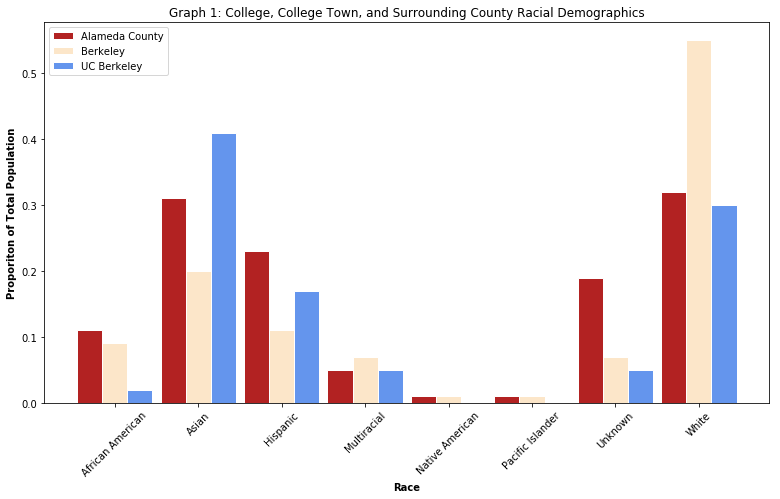

In [19]:
e = plt.figure(figsize=(13,7))
barWidth = 0.30
ind = np.arange(8)

county = df_counties.loc['alameda-ca'].values
univ = (df_800.loc[df_800['name'] == 'university-of-california---berkeley']).drop(columns = ['ranking', 'name'])
city = df_cities.loc['berkeley-ca'].values

b1 = np.arange(len(county))
b2 = b1+barWidth
b3 = b2+barWidth

e.suptitle('')

plt.title("Graph 1: College, College Town, and Surrounding County Racial Demographics")
plt.bar(b1, county, color='#B22222', width=barWidth, edgecolor='white', label='Alameda County')
plt.bar(b2, city, color='#FCE6C9', width=barWidth, edgecolor='white', label='Berkeley')
plt.bar(b3, univ.values[0], color='#6495ED', width=barWidth, edgecolor='white', label='UC Berkeley')

plt.xlabel('Race', fontweight='bold')
plt.ylabel('Proporiton of Total Population', fontweight='bold')
plt.xticks(ind + barWidth, df_counties.columns)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='center')

plt.legend()


At a glance we can see that the difference in proportion of race between these 3 variables can seem quite significant. Interestingly, it seems as if the Alameda county distribution is closer to UC Berkeley distribution than the City of Berkeley. UC Berkeley shows a very drastic difference with the City of Berkeley in the proportion of African American, Asian, and White people in in those populations. On the other hand, when comparing UC Berkeley with the county of Alameda, the most apparent differences are in the proportion of African American, Asian, Hispanic and Unknown people. Simply from this, we can somewhat predict that a statistically significant may be present in the data.

#### We can also do a simple linear visualization between the county data and the university data.

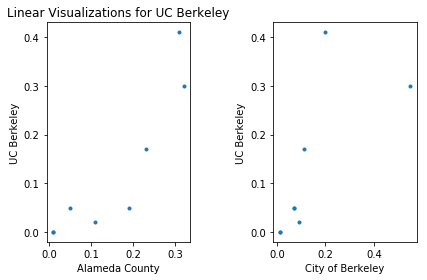

In [20]:
county = df_counties.loc['alameda-ca']
univ = ((df_800.loc[df_800['name'] == 'university-of-california---berkeley']).drop(columns = ['ranking', 'name']).values.astype(float))
city = df_cities.loc['berkeley-ca']
univ = np.squeeze(univ)

f, ax = plt.subplots()
plt.subplot(1,2,1)
plt.plot(county, univ, ".")
plt.xlabel('Alameda County');
plt.ylabel('UC Berkeley');
plt.title('Linear Visualizations for UC Berkeley')

plt.subplot(1,2,2)
plt.plot(city, univ, ".")
plt.xlabel('City of Berkeley');
plt.ylabel('UC Berkeley');

plt.tight_layout()
plt.show()

The Linear visualizations above allows us to see the linear relationships between the city, the county, and UC Berkeley. We can check at a glance how well these two variables relate to each other linearly. It seems that both of these values could have a linear relationship, but they each also seem to have one or two outliers. Alameda county does seem to have a less dramatic outlier, so it may have a better fit. These visualizations tell us that there does seem to be a bit of a positive linear relationship between The University and its respective county and city.

In [21]:
dat = np.column_stack((county,univ))
df = pd.DataFrame(dat, columns=['D1', 'D2'])
outcome, predictors = patsy.dmatrices('D2 ~ D1', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     D2   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     23.12
Date:                Thu, 06 Jun 2019   Prob (F-statistic):            0.00298
Time:                        20:28:05   Log-Likelihood:                 10.434
No. Observations:                   8   AIC:                            -16.87
Df Residuals:                       6   BIC:                            -16.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0416      0.044     -0.950      0.3

The sample size we use is much too small to get valid results, but we can still analyze them for our own purposes. We can check or goodness of fit by looking at the R-Squared and Adjusted R-Squared value we see that we have a fairly strong correlation, so the county data has a somewhat linear relationship with the university data. If one simply look at the values in this test, we can interpret that the results showed a statistically significant difference and that we should reject our null hypothesis. Looking closer, we understand that the sample size is much too small.  

As one can see, there doesn't seem to be much that can be gleaned from looking at only these 2 sections of data. The purpose of this exercise was not to get statistically significant evidence, but for us to visualize the small pieces in a way that helps us predict what may be happening in the bigger picture. From the little exploration that has been done, we can move forward in our analysis with a rough understanding of our data set.

# Data Analysis & Results

## A note about how we measure a racial diversity score in the analysis below:
For all analysis below, we calculate a Diversity Score to quantitatively show the racial demographics of each university or county. Because there are so many different variables, we must create one value which we can compare universities and counties. In order to find a Diversity Score, we record which racial group serves as that regions majority, and calculate the mean percentage with all other remaining racial groups. We know that the majority can sometimes be disproportionately large and might offer us incorrect information regarding the spread of racial groups. Subtracting the majority group from the mean of all other groups, we have a measure of how much the majority overpowers the remaining groups. This helps us in understanding diversity, because if this number is large, it is safe to assume there is little diversity.

## Analysis 1
### For the first part of the analysis, we are interested in looking at how racial demographic data of colleges compares with their surrounding county. 

In [22]:
#function to add a var plot comparing the racial demographic data for a university and the surrounding county
def bar_plot_county_city(county_name, college_name, top_mid_bot, county_color, college_color):
    ind = np.arange(8) 
    width = 0.42

    plt.bar(ind, df_counties.loc[county_name].values, width, label = ""+county_name+" (county)", color = county_color)
    df_temp = (df_800.loc[df_800['name'] == college_name]).drop(columns = ['ranking', 'name'])
    plt.bar(ind + width, df_temp.values[0], width, label = ""+college_name+" (college)", color = college_color)

    plt.xticks(ind + width / 2, df_counties.columns)
    plt.ylabel('Percentage of Total Population')
    plt.title('Ethnicity Percentages for ' + top_mid_bot + ' 3 Ranked County & University')
    plt.legend(loc='best')
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')


In the following bar graphs, the absence of a bar denotes less than 0 percent of the population.

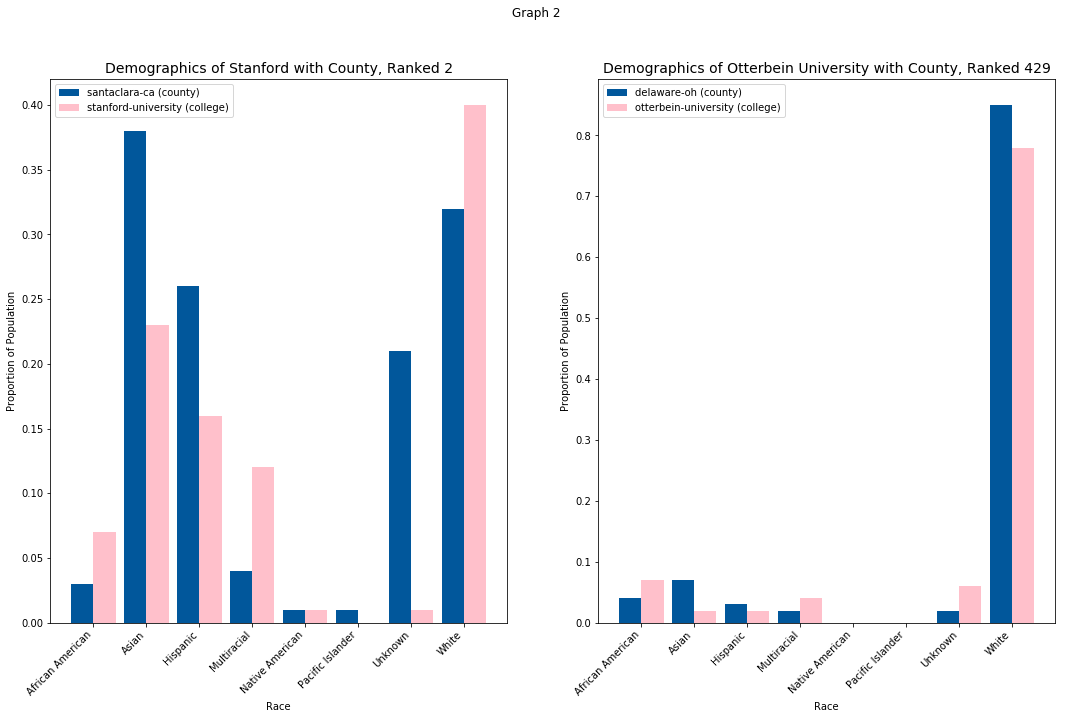

In [23]:
f = plt.figure(figsize=(18,10))
f.suptitle('Graph 2')

plt.subplot(1,2,1)
bar_plot_county_city('santaclara-ca', 'stanford-university', 'Top', '#01579b', "pink")
plt.title("Demographics of Stanford with County, Ranked 2", fontsize = 14)
plt.xlabel('Race')
plt.ylabel('Proportion of Population')

plt.subplot(1,2,2)
bar_plot_county_city('delaware-oh', 'otterbein-university', 'Middle', '#01579b', 'pink')
plt.title("Demographics of Otterbein University with County, Ranked 429", fontsize = 14)
plt.xlabel('Race')
plt.ylabel('Proportion of Population')

plt.show()

The graphs above show the possible variation. Stanford, with a high "Best Colleges" ranking of 2 clearly has racial demographic data very different from the surrounding county. On the other hand, Otterbein University, a college ranked at 429 has less diversity, but has demographics very similar to the surrounding county of Delaware, Ohio.

We are therefore interested in looking at whether ranking is correlated with not only how diverse racial demographics of a campus are, but also how that spread compares with the surrounding city.

## Question: Is there a relationship between the ranking tier (top, middle, bottom) and the similarity between the college and surrounding county demographics?

#### Hypothesis: Top-ranked universities tend to be magnet schools and pull students from all over the nation. Also, in our experience, there is more pressure for top-ranked schools to be racially diverse, whereas counties don't often have racial demographics split equally. Hence, our intuition is that their demographics will not match the counties. Lower-ranked universities often have local students. We hypothesize that lower ranked schools will have higher racial demographic similarity with the surrounding county. 

#### Summary: To answer this question, we create a "diversity metric", a single value for each college or county, to compare. We do this for the top 3 (1-3), middle 3 (429-431), and bottom 3 (878-880) ranked colleges. 

#### Limitations: We recognize that 9 datapoints in 3 different categories ("top", "middle", and "bottom") is not enough to create accurate inferences. However, for each county, we need to manually download data. Hence, due to time constraints, we cannot do this analysis with as much data as we would like. We will be cautious of this while making inferences. 

### Step 1: Before we compare each of the colleges with their counties, we do the analysis for colleges and counties separately.

First, we create the dataframe just including the college data for the top 3, middle 3, and bottom 3 colleges.

In [24]:
df_topmidbot = df_800[:3]
df_topmidbot = df_topmidbot.append([df_800[428:431], df_800[877:881]])
df_topmidbot = df_topmidbot.drop(columns=["name"]) # name is unnecessary information for this analysis
df_topmidbot.index = df_topmidbot["ranking"]
df_topmidbot.index.names = ['orig_rank']
df_topmidbot.ranking = pd.to_numeric(df_topmidbot["ranking"]) #ranking was previously a string value
df_topmidbot.loc[:,["African American", "Asian", "Hispanic","Multiracial","Pacific Islander", "Native American", "Unknown", "White"]]

,African American,Asian,Hispanic,Multiracial,Pacific Islander,Native American,Unknown,White
orig_rank,,,,,,,,
1,0.07,0.28,0.17,0.07,0,0,0.02,0.39
2,0.07,0.23,0.16,0.12,0,0.01,0.01,0.4
3,0.07,0.22,0.12,0.06,0,0,0.04,0.49
429,0.07,0.02,0.02,0.04,0,0,0.06,0.78
430,0.04,0.02,0.06,0.04,0,0,0,0.84
431,0.13,0.01,0.09,0.04,0,0,0,0.73
878,0.05,0.01,0.03,0.02,0,0,0.06,0.83
879,0.06,0.06,0.66,0.03,0,0,0.04,0.14
880,0.04,0.04,0.14,0.03,0,0.03,0.11,0.61


Then, we must create the "diversity metric". We initially tested using the mean as the metric, but for most colleges the metric was .19 or .20. This meant that all of the colleges and counties had the same diversity value, which is clearly not the case, as seen in Graph 1. Hence, we decided to use the variance for each college row as the metric because the value gives more information about dispersion of the racial demographics.

In [25]:
#make columns to store mean, majority, and diversity rating
df_topmidbotspread =  df_topmidbot[["African American", "Asian", "Hispanic","Multiracial","White"]]
df_topmidbot["Majority"] = df_topmidbotspread.max(axis=1)

#set majority values to 0 
count = 0
for i,j in df_topmidbot.iterrows():
    if j['African American'] == j['Majority']:
        df_topmidbot.at[i, 'African American'] = 0 
    if j['Asian'] == j['Majority']:
        df_topmidbot.at[i, 'Asian'] = 0 
    if j['Hispanic'] == j['Majority']:
        df_topmidbot.at[i, 'Hispanic'] = 0 
    if j['Multiracial'] == j['Majority']:
        df_topmidbot.at[i, 'Multiracial'] = 0 
    if j['White'] == j['Majority']:
        df_topmidbot.at[i, 'White'] = 0
        

df_topmidbot["mean"] = df_topmidbot.loc[:, ["African American", "Asian", "Hispanic","Multiracial","Pacific Islander", "Native American", "Unknown", "White"]].mean(axis=1)
df_topmidbot['Diversity'] = 1-(df_topmidbot['Majority'] - df_topmidbot['mean'])
print("Diversity Metric of Universities")
df_topmidbot.loc[:, "Diversity"]

Diversity Metric of Universities


orig_rank
1      0.69
2      0.68
3      0.57
429    0.25
430    0.18
431    0.30
878    0.19
879    0.38
880    0.44
Name: Diversity, dtype: float64

In [26]:
# College Data
# To get "top", "middle", "bottom" categories, change ranking to values of 0-2.
df_topmidbot.ranking.loc[(df_topmidbot['ranking'] < 4)] = 0
df_topmidbot.ranking.loc[(df_topmidbot['ranking'] >= 4) & (df_topmidbot['ranking'] < 432)] = 1
df_topmidbot.ranking.loc[(df_topmidbot['ranking'] > 877)] = 2

# County data
#remove Alameda, which is used for exploratory phase, and is not needed for Analysis 1
df_topmidbot_county = df_counties.drop("alameda-ca")
df_topmidbot_county["ranking"] = [0,0,0,1,1,1,2,2,2]
df_topmidbot_county = df_topmidbot_county.copy(deep=True)
#calculate , mean, Majority, then Diversity according to our method described above
df_topmidbot_countyspread =  df_topmidbot_county[["African American", "Asian", "Hispanic","Multiracial","White"]]
df_topmidbot_county["Majority"] = df_topmidbot_countyspread.max(axis=1)

count = 0
for i,j in df_topmidbot_county.iterrows():
    if j['African American'] == j['Majority']:
        df_topmidbot_county.at[i, 'African American'] = 0 
    if j['Asian'] == j['Majority']:
        df_topmidbot_county.at[i, 'Asian'] = 0 
    if j['Hispanic'] == j['Majority']:
        df_topmidbot_county.at[i, 'Hispanic'] = 0 
    if j['Multiracial'] == j['Majority']:
        df_topmidbot_county.at[i, 'Multiracial'] = 0 
    if j['White'] == j['Majority']:
        df_topmidbot_county.at[i, 'White'] = 0
        

df_topmidbot_county["mean"] = df_topmidbot_county.loc[:, ["African American", "Asian", "Hispanic","Multiracial","Pacific Islander", "Native American", "Unknown", "White"]].mean(axis=1)
df_topmidbot_county['Diversity'] = 1-(df_topmidbot_county['Majority'] - df_topmidbot_county['mean'])
print("Diversity Metric of Counties")
df_topmidbot_county.loc[:, "Diversity"]

Diversity Metric of Counties


middlesex-ma        0.33
santaclara-ca       0.73
newhaven-ct         0.44
delaware-oh         0.17
walworth-wi         0.18
morgan-il           0.13
westmoreland-pa     0.07
sanbernardino-ca    0.59
shasta-ca           0.24
Name: Diversity, dtype: float64

Text(0, 0.5, 'Diversity Metric')

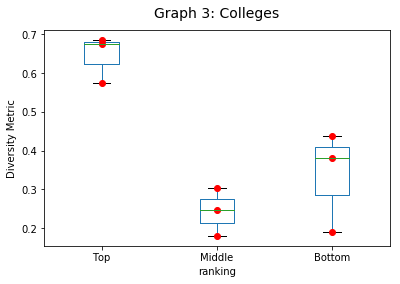

In [27]:
graph2 = df_topmidbot.boxplot(by ='ranking',column =['Diversity'], grid = False) 
plt.plot(df_topmidbot["ranking"]+1, df_topmidbot["Diversity"],'r.',alpha=1,marker='o')
plt.suptitle("Graph 3: Colleges", fontsize = 14)
plt.title("")
plt.xticks([1, 2, 3], ['Top', 'Middle', 'Bottom'])
graph2.set_ylabel('Diversity Metric')

This graph suggests 3 things:
1. top colleges have a high diversity rating, and hence have more equal proportions for various races. 
2. as ranking increases (Middle and bottom tier), there is more variability in diversity between colleges of similar rankings.
3. While there is an overall decrease in the diversity metric, there does not seem to be a linear relationship.

Text(0, 0.5, 'Diversity Metric')

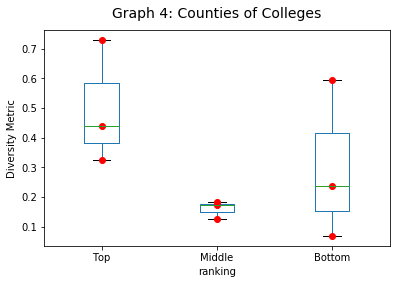

In [28]:
graph3 = df_topmidbot_county.boxplot(by ='ranking', column =['Diversity'], grid = False) 
plt.plot(df_topmidbot_county["ranking"]+1, df_topmidbot_county["Diversity"],'r.',alpha=1,marker='o')
plt.xticks([1, 2, 3], ['Top', 'Middle', 'Bottom'])
plt.suptitle("Graph 4: Counties of Colleges", fontsize = 14)
plt.title("")
graph3.set_ylabel('Diversity Metric')

This graph suggests 3 things:
1. There is a similar trend in the diversity metric means as the graph 2 of universities.
2. The trend of variability is not consistent; however, the counties of the bottom ranked category also have the highest variability.
3. There is an overall decrease in the diversity metric (less equal proportions), but not a linear trend.

### Step 2: Compare each of the colleges with their counties

#### First, we create a dataframe with the difference between the diversity metric of universities and their surrounding counties.

In [29]:
df_topmidbot_county = df_topmidbot_county.set_index("ranking") # set index so same as df_topmidbot_county index
df_summary = df_topmidbot_county["Diversity"].sub(df_topmidbot["Diversity"], axis = 0).to_frame() 
df_summary.columns = ["Diversity Difference"]

Text(0, 0.5, 'Difference between College and County Diversity Metric')

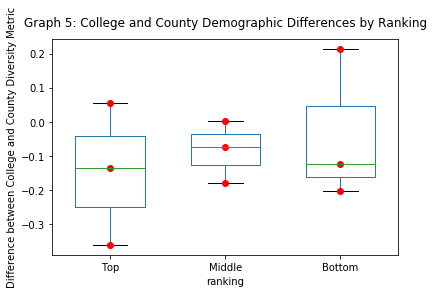

In [30]:
graph4 = df_summary.boxplot(by ='ranking', column =['Diversity Difference'], widths = 0.6,grid = False)
plt.suptitle("Graph 5: College and County Demographic Differences by Ranking")
plt.title("")
plt.plot(df_summary.index+1, df_summary["Diversity Difference"],'r.',alpha=1,marker='o')
plt.xticks([1, 2, 3], ['Top', 'Middle', 'Bottom'])
graph4.set_ylabel('Difference between College and County Diversity Metric')

The graph suggests that there is in fact a slight correlation as the overall trend of diversity difference does increase. The correlation seems weak, primarily because there are only 9 data points. However, we will do a linear regression analysis to determine the extent of this correlation.

In [31]:
print("OLS Regression for top tier")
df_var_summary = pd.DataFrame(columns = ['county', 'college']) 
df_var_summary['college'] = df_topmidbot.loc[df_topmidbot["ranking"] == 0]['Diversity'].values
df_var_summary['county'] = df_topmidbot_county['Diversity'].values[:3]

outcome, predictors = patsy.dmatrices('college ~ county', df_var_summary)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

OLS Regression for top tier
                            OLS Regression Results                            
Dep. Variable:                college   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.951
Method:                 Least Squares   F-statistic:                   0.02504
Date:                Thu, 06 Jun 2019   Prob (F-statistic):              0.900
Time:                        20:28:07   Log-Likelihood:                 4.7323
No. Observations:                   3   AIC:                            -5.465
Df Residuals:                       1   BIC:                            -7.267
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6219   

In [32]:
print("OLS Regression for middle tier")
df_var_summary['college'] = df_topmidbot.loc[df_topmidbot["ranking"] == 1]['Diversity'].values
df_var_summary['county'] = df_topmidbot_county['Diversity'].values[3:6]

outcome, predictors = patsy.dmatrices('college ~ county', df_var_summary)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

OLS Regression for middle tier
                            OLS Regression Results                            
Dep. Variable:                college   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     5.689
Date:                Thu, 06 Jun 2019   Prob (F-statistic):              0.253
Time:                        20:28:07   Log-Likelihood:                 7.5475
No. Observations:                   3   AIC:                            -11.09
Df Residuals:                       1   BIC:                            -12.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5486

In [33]:
print("OLS Regression for bottom tier")
df_var_summary['college'] = df_topmidbot.loc[df_topmidbot["ranking"] == 2]['Diversity'].values
df_var_summary['county'] = df_topmidbot_county['Diversity'].values[6:9]

outcome, predictors = patsy.dmatrices('college ~ county', df_var_summary)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

OLS Regression for bottom tier
                            OLS Regression Results                            
Dep. Variable:                college   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                 -0.326
Method:                 Least Squares   F-statistic:                    0.5079
Date:                Thu, 06 Jun 2019   Prob (F-statistic):              0.606
Time:                        20:28:07   Log-Likelihood:                 3.0991
No. Observations:                   3   AIC:                            -2.198
Df Residuals:                       1   BIC:                            -4.001
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2530

As seen from the OLS regression results above, the p values of the parameter, county, is always greater than our alpha significance level (0.01), meaning that there no significant difference. Thus, we will not reject the null hypothesis. However, the p value does decrease from top level colleges/cities to mid and bottom level colleges/cities indicating that there is more correlation between mid and bottom level colleges/cities than between top level colleges/cities.

# Analysis 2

## For the second part of the analysis, we're looking to see if we can find a correlation between the racial diversity of a university vs. the size of the undergraduate population.

The first step is to combine the population data with the diversity data so we can run analyses in a more organized manner.

In [34]:
#get racial demographic data

df_niche = pd.read_csv("datasets/niche4yearpublicprivate.csv")

# Data wrangling from csv file
df_columns = df_niche[['African American', 'Asian', 'Hispanic', 'International', 'Multiracial', 'Native American','Pacific Islander', 'Unknown', 'White']]
df_niche = df_niche.drop("International", axis=1)
for indexr, university in df_niche.iterrows():
    sum = 0
    for indexc, newvalue in university.iteritems():
        if "%" in str(newvalue):
            oldvalue = (newvalue)
            newvalue = (float(newvalue.rstrip("%"))) / 100
            df_niche.loc[indexr,indexc] = newvalue
            sum = sum + newvalue
    for indexc, newvalue in university.iteritems():
        if isinstance(df_niche.loc[indexr,indexc], float):
            df_niche.loc[indexr,indexc] = round((float(df_niche.loc[indexr,indexc]) / sum),2)

df_niche_800 = df_niche
df_niche = df_niche.head(500) #top 500 colleges
df_niche_800.loc[:,['African American', 'Asian', 'Hispanic', 'Multiracial', 'Native American','Pacific Islander', 'Unknown', 'White']]

,African American,Asian,Hispanic,Multiracial,Native American,Pacific Islander,Unknown,White
0,0.07,0.28,0.17,0.07,0,0,0.02,0.39
1,0.07,0.23,0.16,0.12,0.01,0,0.01,0.4
2,0.07,0.22,0.12,0.06,0,0,0.04,0.49
3,0.07,0.19,0.14,0.06,0.01,0,0.04,0.49
4,0.08,0.23,0.1,0.05,0,0,0.07,0.47
...,...,...,...,...,...,...,...,...
875,0.19,0.1,0.32,0.04,0,0,0.08,0.27
876,0.04,0.16,0.16,0.04,0,0,0.07,0.51
877,0.05,0.01,0.03,0.02,0,0,0.06,0.83
878,0.06,0.06,0.66,0.03,0,0,0.04,0.14


In [35]:
#get undergraduate size data
df_niche_pop = pd.read_csv("datasets/undergradpop.csv")
for indexr, university in df_niche_pop.iterrows():
    newvalue = int(university[2])
    df_niche_pop.loc[indexr,"undergradpop"] = newvalue
df_niche_pop

,ranking,name,undergradpop
0,1,massachusetts-institute-of-technology,4510
1,2,stanford-university,7064
2,3,harvard-university,7147
3,4,yale-university,5743
4,5,princeton-university,5260
...,...,...,...
495,496,concordia-university---nebraska,1231
496,497,university-of-texas---arlington,17819
497,498,saint-johns-university---minnesota,1703
498,499,fresno-pacific-university,2342


In [36]:
#all racial demographic, undergraduate population info for top 500 universities (4 year public and private)
df_top500 = pd.concat([df_niche, df_niche_pop.undergradpop], axis=1)
df_top500 = df_top500[['ranking','name','undergradpop','African American', 'Asian', 'Hispanic', 'Multiracial', 'Native American','Pacific Islander', 'Unknown', 'White']]
df_top500.loc[:, ["undergradpop",'African American', 'Asian', 'Hispanic', 'Multiracial', 'Native American','Pacific Islander', 'White']]

,undergradpop,African American,Asian,Hispanic,Multiracial,Native American,Pacific Islander,White
0,4510,0.07,0.28,0.17,0.07,0,0,0.39
1,7064,0.07,0.23,0.16,0.12,0.01,0,0.4
2,7147,0.07,0.22,0.12,0.06,0,0,0.49
3,5743,0.07,0.19,0.14,0.06,0.01,0,0.49
4,5260,0.08,0.23,0.1,0.05,0,0,0.47
...,...,...,...,...,...,...,...,...
495,1231,0.04,0.01,0.05,0.01,0,0,0.78
496,17819,0.17,0.11,0.27,0.03,0,0,0.43
497,1703,0.05,0.03,0.07,0.01,0,0,0.83
498,2342,0.05,0.04,0.48,0.02,0.01,0.01,0.32


Now, we have created one dataframe 'df_top500', that includes school ranking, population size, as well as the racial demographics for each university. For this analysis, we only use the top 500 (instead of 800) ranked universities because between 500 and 800, there was a lot of missing data on Niche.com.

## Question: Can university size/undergraduate population predict the diversity of a student body? 

#### Hypothesis: Larger unviersities represent a more diverse student body compared to smaller universities. We predict the top tier of undergraduate population are more diverse because bigger universities pull more student applications and therefore are exposed to a more pool of potential students. 

#### Summary: To answer this question, we create a "diversity score", a single value for each college to compare. We do this for each university and after sorting universities into the top third, middle third, and bottom third based on population, this score helps us determine if there is a trend in our data.

#### Limitations: We recognize that we have a skewed sample in which we are exposed to more data from smaller schools than larger schools. There are also two categories, 'unknown' and 'bi-racial', that keeps us from seeing a "true" measurement. 

To first see a possible trend in the data, we plotted each race's respective proportion on the axis of 'School Population', meaning school size.

Text(0.5, 1.0, 'Native American Representation in Top 500 Universities')

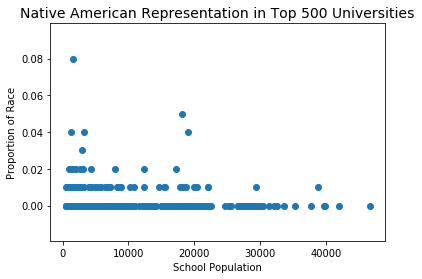

In [37]:
plt.scatter(df_top500.undergradpop, df_top500["Native American"])
plt.xlabel('School Population')
plt.ylabel('Proportion of Race')
plt.title('Native American Representation in Top 500 Universities', fontsize = 14)

After building scatter plots for each racial demographic, we found that these graphs were not sufficient to explain any possible correlation between our variables. The scatter plot above is one example, looking at specifically the Native American population in universities.

Our next objective was to sort the top 500 universities based on their undergraduate populations. Our intention was that this would help display a more intuitive correlation. This will also help us later on when we divide our dataframe. 

In [38]:
df_sorted = df_top500.sort_values(by=['undergradpop'])
df_sorted.loc[:,["name","undergradpop"]]

,name,undergradpop
206,st-louis-college-of-pharmacy,435
386,franciscan-missionaries-of-our-lady-university,494
447,adventhealth-university,575
459,university-of-new-hampshire-at-manchester,575
207,baptist-health-system-school-of-health-profess...,597
...,...,...
160,arizona-state-university,38814
88,penn-state,39785
190,university-of-central-florida,39962
90,the-ohio-state-university,42003


We again run a scatter plot for each racial demographic vs. undergraduate size. Below are all scatter plots we deemed would offer information. The categories of "Unknown" and "Biracial" are not represented because of their potential to skew the data.

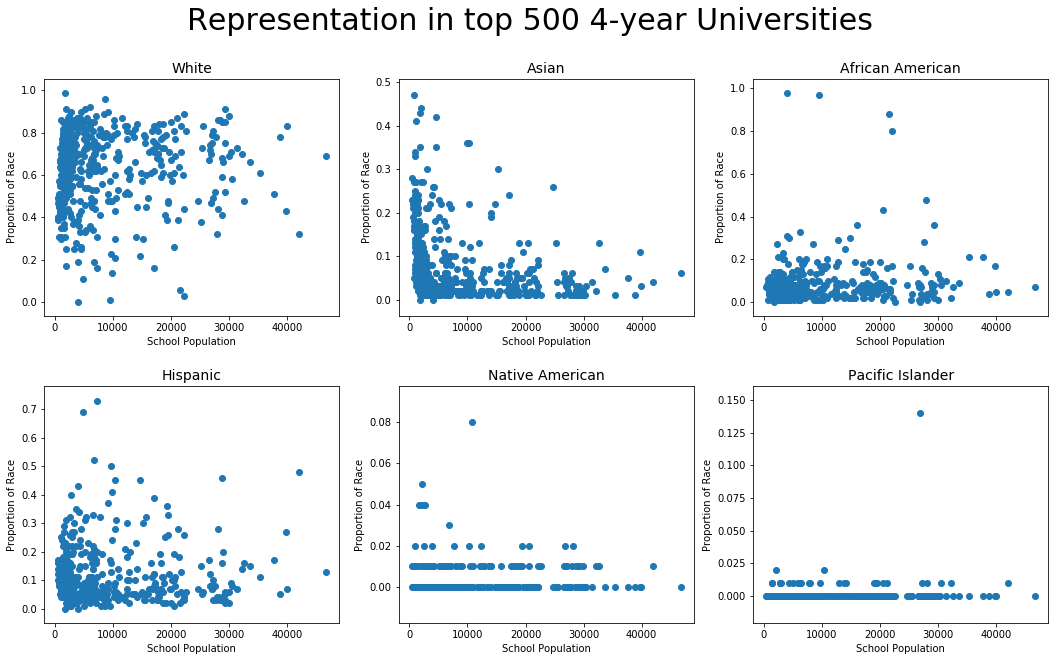

In [39]:

g = plt.figure(figsize=(18,10))

plt.subplot(2,3,1)
plt.scatter(df_sorted.undergradpop, df_top500["White"])
plt.xlabel('School Population')
plt.ylabel('Proportion of Race')
plt.title('White', fontsize = 14)

plt.subplot(2,3,2)
plt.scatter(df_sorted.undergradpop, df_top500["Asian"])
plt.xlabel('School Population')
plt.ylabel('Proportion of Race')
plt.title('Asian', fontsize = 14)

plt.subplot(2,3,3)
plt.scatter(df_sorted.undergradpop, df_top500["African American"])
plt.xlabel('School Population')
plt.ylabel('Proportion of Race')
plt.title('African American', fontsize = 14)

plt.subplot(2,3,4)
plt.scatter(df_sorted.undergradpop, df_top500["Hispanic"])
plt.xlabel('School Population')
plt.ylabel('Proportion of Race')
plt.title('Hispanic', fontsize = 14)

plt.subplot(2,3,5)
plt.scatter(df_sorted.undergradpop, df_top500["Native American"])
plt.xlabel('School Population')
plt.ylabel('Proportion of Race')
plt.title('Native American', fontsize = 14)

plt.subplot(2,3,6)
plt.scatter(df_sorted.undergradpop, df_top500["Pacific Islander"])
plt.xlabel('School Population')
plt.ylabel('Proportion of Race')
plt.title('Pacific Islander', fontsize = 14)

g.suptitle("Representation in top 500 4-year Universities", fontsize=30)
g.subplots_adjust(hspace=.3)

These visualizations not only show that there aren't substantial mistakes throughout the data, and the spreads are generally what we would expect. The data is concentrated in schools that are less than 20,000 students (because there are more schools with undergraduate populations of this size). Schools also generally have more White students, and Native American and Pacific Islander student populations are generally consistently close to 0%  regardless of the population size.

From these graphs, we recorded each pearson correlation coefficient to get a quantitative representation of how this data looks:

In [40]:
print('Pearsons correlation coefficient for the Asian population = %.3f (p=%.3f)' % (pearsonr(df_sorted['undergradpop'], df_sorted['Asian'])[0], pearsonr(df_sorted['undergradpop'], df_sorted['Asian'])[1]))
print('Pearsons correlation coefficient for the African American population= %.3f (p=%.3f)' % (pearsonr(df_sorted['undergradpop'], df_sorted['African American'])[0], pearsonr(df_sorted['undergradpop'], df_sorted['African American'])[1]))
print('Pearsons correlation coefficient for the Hispanic population = %.3f (p=%.3f)' % (pearsonr(df_sorted['undergradpop'], df_sorted['Hispanic'])[0], pearsonr(df_sorted['undergradpop'], df_sorted['Hispanic'])[1]))
print('Pearsons correlation coefficient for the Native American population = %.3f (p=%.3f)' % (pearsonr(df_sorted['undergradpop'], df_sorted['Native American'])[0], pearsonr(df_sorted['undergradpop'], df_sorted['Native American'])[1]))
print('Pearsons correlation coefficient for the Pacific Islander population = %.3f (p=%.3f)' % (pearsonr(df_sorted['undergradpop'], df_sorted['Pacific Islander'])[0], pearsonr(df_sorted['undergradpop'], df_sorted['Pacific Islander'])[1]))
print('Pearsons correlation coefficient for the White population = %.3f (p=%.3f)' % (pearsonr(df_sorted['undergradpop'], df_sorted['White'])[0], pearsonr(df_sorted['undergradpop'], df_sorted['White'])[1]))


Pearsons correlation coefficient for the Asian population = 0.225 (p=0.000)
Pearsons correlation coefficient for the African American population= -0.003 (p=0.939)
Pearsons correlation coefficient for the Hispanic population = 0.172 (p=0.000)
Pearsons correlation coefficient for the Native American population = -0.070 (p=0.120)
Pearsons correlation coefficient for the Pacific Islander population = -0.055 (p=0.220)
Pearsons correlation coefficient for the White population = -0.153 (p=0.001)


The Pearson correlation coefficent here further shows a lack of 'strong correlation' in the data. As we can see, each R value is close to 0, representing little to no relationship between our variables (population size and racial representation).

### Diversity: In order to create a quantitative score for diversity, we measured the values of the school's majority race between all other races.
As explained at the top of Analysis, our 'diversity score' is calculated by comparing the 'majority' race to the remaining racial demographics.

In [41]:
df_top500spread = df_top500[["African American","Asian","Hispanic","Native American","Pacific Islander","White"]]
df_top500["Majority"] = df_top500spread.max(axis=1)
count = 0
for i,j in df_top500.iterrows():
    if j['African American'] == j['Majority']:
        df_top500.at[i, 'African American'] = 0 
    if j['Asian'] == j['Majority']:
        df_top500.at[i, 'Asian'] = 0 
    if j['Hispanic'] == j['Majority']:
        df_top500.at[i, 'Hispanic'] = 0 
    if j['Native American'] == j['Majority']:
        df_top500.at[i, 'Native American'] = 0 
    if j['Pacific Islander'] == j['Majority']:
        df_top500.at[i, 'Pacific Islander'] = 0 
    if j['White'] == j['Majority']:
        df_top500.at[i, 'White'] = 0

In [42]:
df_top500["var"] =  df_top500.loc[:, ["African American", "Asian", "Hispanic","Multiracial","Pacific Islander", "Native American", "Unknown", "White"]].var(axis=1)
df_top500["mean"] = df_top500.loc[:, ["African American", "Asian", "Hispanic","Multiracial","Pacific Islander", "Native American", "Unknown", "White"]].mean(axis=1)
df_sorted = df_top500.sort_values(by=['undergradpop'])
df_top500['Diversity'] = 1-(df_sorted['Majority'] - df_sorted['mean'])
print("Diversity metric of Top 500 Universities")
df_top500.loc[:, ["undergradpop", "Diversity"]]

Diversity metric of Top 500 Universities


,undergradpop,Diversity
0,4510,0.69
1,7064,0.68
2,7147,0.57
3,5743,0.57
4,5260,0.60
...,...,...
495,1231,0.25
496,17819,0.64
497,1703,0.19
498,2342,0.58


Now, each university has a Diversity column, whose magnitude indicates how diverse we can call the university.

Here, we are sorting the colleges based upon their undergraduate population/enrollment. We have them split evenly due to the fact that we have a disproportionate amount of larger colleges vs smaller, and so it would provide less accurate results because there is more data being analyzed for some groups than others.
We create three new dataframes so we can analyze the top third, middle third, and bottom third of college populations from the 500 top ranked universities. The top third will represent the smallest third of colleges and so on.

In [43]:
df_top500 = df_top500.sort_values(by = 'undergradpop')
df_split = np.array_split(df_top500, 3)
df_top = pd.DataFrame(df_split[0])
df_mid = pd.DataFrame(df_split[1])
df_bot = pd.DataFrame(df_split[2])

The three following scatter plots were built to analyze 'Diversity' against 'School Population' for each tier of school size in a more in depth level.

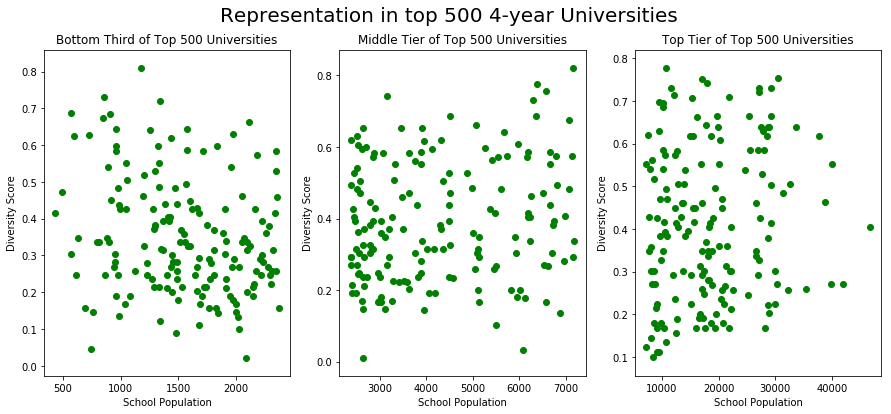

In [44]:
h = plt.figure(figsize=(15, 6))

plt.subplot(1,3,1)
plt.scatter(df_top.undergradpop, df_top['Diversity'], c = 'green')
plt.xlabel('School Population')
plt.ylabel('Diversity Score')
plt.title('Bottom Third of Top 500 Universities', fontsize = 12)

plt.subplot(1,3,2)
plt.scatter(df_mid.undergradpop, df_mid['Diversity'], c = 'green')
plt.xlabel('School Population')
plt.ylabel('Diversity Score')
plt.title('Middle Tier of Top 500 Universities', fontsize = 12)

plt.subplot(1,3,3)
plt.scatter(df_bot.undergradpop, df_bot['Diversity'], c = 'green')
plt.xlabel('School Population')
plt.ylabel('Diversity Score')
plt.title('Top Tier of Top 500 Universities', fontsize = 12)

h.suptitle("Representation in top 500 4-year Universities", fontsize=20)
h.subplots_adjust(hspace=.8)

One thing to note is that school size seems to be correlated with the school tier. As the tier improves, the population increases, which makes sense as more popular universities will attract more students. 
We recorded diversity through the above scatter plots and concluded that there is not an easily identifiable trend from dividing each school population into three groups. From here we ran a test in order to see if there is an un-identified trend between diversity and population that we could not see through the scatter plots.

In [45]:
print("OLS Regression for top tier")
outcome, predictors = patsy.dmatrices('undergradpop ~ Diversity', df_top)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

OLS Regression for top tier
                            OLS Regression Results                            
Dep. Variable:           undergradpop   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     8.996
Date:                Thu, 06 Jun 2019   Prob (F-statistic):            0.00312
Time:                        20:28:14   Log-Likelihood:                -1267.1
No. Observations:                 167   AIC:                             2538.
Df Residuals:                     165   BIC:                             2544.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1790.1582   

In [46]:
print("OLS Regression for middle tier")
outcome, predictors = patsy.dmatrices('undergradpop ~ Diversity', df_mid)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

OLS Regression for middle tier
                            OLS Regression Results                            
Dep. Variable:           undergradpop   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     5.071
Date:                Thu, 06 Jun 2019   Prob (F-statistic):             0.0257
Time:                        20:28:14   Log-Likelihood:                -1460.1
No. Observations:                 167   AIC:                             2924.
Df Residuals:                     165   BIC:                             2930.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3663.9585

In [47]:
print("OLS Regression for bottom tier")
outcome, predictors = patsy.dmatrices('undergradpop ~ Diversity', df_bot)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

OLS Regression for bottom tier
                            OLS Regression Results                            
Dep. Variable:           undergradpop   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.094
Date:                Thu, 06 Jun 2019   Prob (F-statistic):              0.150
Time:                        20:28:14   Log-Likelihood:                -1733.2
No. Observations:                 166   AIC:                             3470.
Df Residuals:                     164   BIC:                             3477.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.643e+04

From these tests, we can see that there is likely no correlation between diversity and school size because the coefficient variable is relatively unsubstantial, with almost no rise or fall in trend. The p-value is also above our alpha value of 0.01, which leads us to fail to reject our null hypothesis of there being no relationship between our variables.

Lastly, we wanted to visually compare the largest, smallest, and medium sized colleges side by side based on their diversity rating. We split these three groups and made a boxplot for each group. Through this we can see very little difference in diversity score based on college population but a little higher variance in the small colleges.

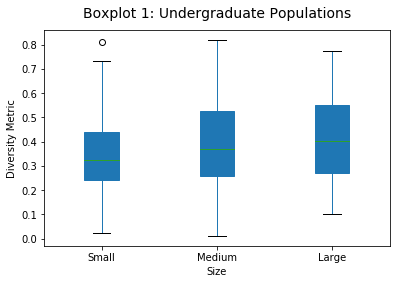

In [48]:
data1 = df_top.assign(Size=1)
data2 = df_mid.assign(Size=2)
data3 = df_bot.assign(Size=3)
cdf = pd.concat([data1,data2,data3])
#mdf = pd.melt(cdf, id_vars=['Size'], var_name=['var'])
boxy = cdf.boxplot(by ='Size', column =['Diversity'], grid = False,patch_artist = True)
plt.xticks([1, 2, 3], ['Small', 'Medium', 'Large'])
plt.suptitle("Boxplot 1: Undergraduate Populations", fontsize = 14)
plt.title("")
boxy.set_ylabel('Diversity Metric')
colors = ['lightblue', 'lightgreen', 'pink']

# Ethics & Privacy

### Data Sources
The data involving higher education-specific demographics was posted on Niche for anyone to view. We were required to contact Niche for specific permission to use/analyze their data for academic purposes. Niche found its statistics from various official public sources including the FBI, the U.S. Census, and the Department of Education. The data from Niche provides us the racial demographics of the student bodies of 810 4-year colleges and universities in the United States. Categories include: African American, Asian, Hispanic, International, Multiracial, Native American, Pacific Islander, Unknown, White. Our analysis might not prefer the categories of ‘Multiracial’ and ‘Unknown’ since these categories can add noise to our final result and do not give us insight into any specific race. There is also a concern for the category ‘White’, because this can represent both Europeans and Middle Easterns, which racially are equivalent but are societally seen as separate. Niche’s data does not include the number of students enrolled nor any information about any one student.

We also utilize city data from the 2010 U.S. Census, looking at city specific racial demographics for cities with populations over 5,000 people: White, Black/African American, American Indian/Alaska Native, Asian, Native Hawaiian/Other Pacific Islander, Two or More Races, Hispanic/Latino. The discrepancy between our data sources’ categories are ‘International’ and ‘Unknown’, which are specific to Niche’s data. Since we do not look into anything more specific than percentages within colleges and cities, we do not invade the personal privacy of our subjects. Aside from what has already been mentioned, we do not anticipate any other issues related to privacy and equitable impact due to the public nature of this dataset (people are aware that their demographics are recorded in college admissions as well as on the U.S. Census).

### Analysis / Post Analysis
The main concern with this data science question is that the results could potentially be used for implementation of racial quotas in universities. If the analysis is not interpreted properly, the results could be used to support policies that move away from merit-based acceptances. 
In post-analysis, our results show that there is no strong relationship. However, we recognize that we had many limitations in our analysis process, so we have a limited analysis with low ecological validity that should not be applied to real-world policies.

# Conclusion & Discussion

In our first analysis, we sought to find out if the racial demographic of universities was statistically different from their surrounding counties. In the start of our analysis we hypothesized that universities would have a lower diversity ranking than the county they are in. Unfortunately, our analysis did not show this trend and therefore we failed to reject the null hypothesis. From the tests we produced, we did manage to find a small trend based on the p-value decreasing from the top level of colleges/cities to middle and bottom level colleges/cities. Thus, there is possibly a correlation between the middle and bottom level colleges as opposed to the top ranking colleges/cities. With our lack of overall correlation, we realize that our results may be due to eliminating categories of data such as “international” students, which could impact our data. 

For our second analysis regarding whether or not there is a correlation between racial diversity of a university and the size of the university's population, we concluded that there is no statistically significant correlation with the data we worked with. At first, we thought that there would be a slight correlation between the universities that have a larger population and the rank of diversity in their student body. It was our assumption that schools with a larger population receive a larger quantity and therefore larger variety of applications as well. That being said, our analysis did not show this trend or any type of relationship, even when we conducted multiple tests, making us fail to reject the null hypothesis. Though, our research has shown to have no correlation between these two factors, it may be because of confounding variables within our data. For example, our data set included “bi-racial” and “multiracial” categories, which we did not analyze because of the lack of clarity given for each of these sets. 

Our previously stated limitations likely caused a larger impact than we previously predicted. Simply looking at the US Census, we can see a national trend of changing proportions of ethnicities. We understood that with a more detailed census, we would have been able to calculate a more accurate representation of our racial proportions. It is likely that the particular age range (18-24 years old) in which we were doing our analysis has different proportions than the age range we worked with. In a future attempt, the best way to do a serious analysis of this data would be to limit the age range in the general population of the cities and the counties. This would focus our data and would hopefully produce a clearer picture of racial proportions in these areas.